C:\Users\bhava\AppData\Local\Temp\ipykernel_1352\3545745165.py:22: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  weather_data["DATE_TIME"] = pd.to_datetime(weather_data["DATE_TIME"], dayfirst=True, errors="coerce")


Merged Data Shape: (68774, 11)
Iter 1/30 - best MSE: 1.416408e-03
Iter 5/30 - best MSE: 1.415492e-03
Iter 10/30 - best MSE: 1.415078e-03
Iter 15/30 - best MSE: 1.414181e-03
Iter 20/30 - best MSE: 1.413830e-03
Iter 25/30 - best MSE: 1.413830e-03
Iter 30/30 - best MSE: 1.413595e-03
Best training MSE (scaled space): 0.0014135946958796935
Test RMSE: 523.0413408753959
Test R^2: 0.9830708278461361


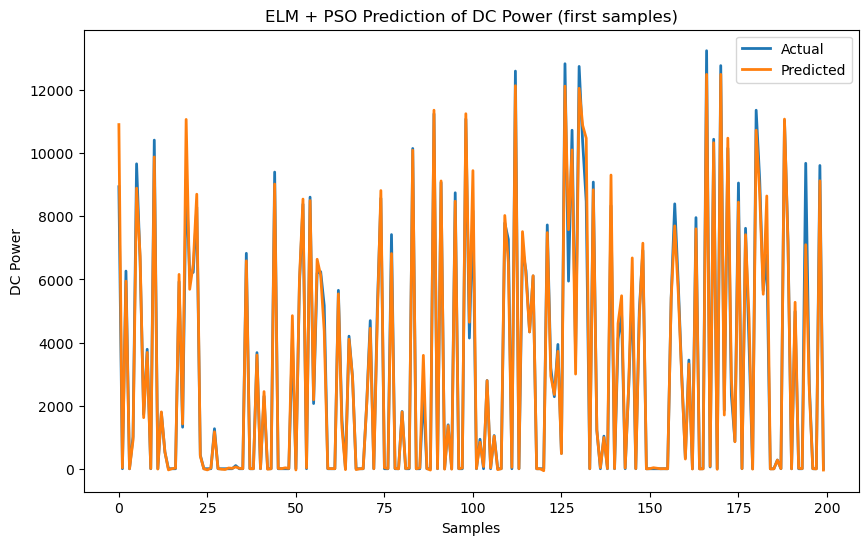

In [2]:
# corrected_elm_pso.py
# Run in a Python environment with numpy, pandas, scikit-learn, matplotlib installed.

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


np.random.seed(42)

gen_path = "Plant_1_Generation_Data.csv"
weather_path = "Plant_1_Weather_Sensor_Data.csv"

gen_data = pd.read_csv(gen_path)
weather_data = pd.read_csv(weather_path)

# Parse datetimes (your data appears to be day-first) — prevent the warning
gen_data["DATE_TIME"] = pd.to_datetime(gen_data["DATE_TIME"], dayfirst=True, errors="coerce")
weather_data["DATE_TIME"] = pd.to_datetime(weather_data["DATE_TIME"], dayfirst=True, errors="coerce")

# Drop rows where DATE_TIME could not be parsed
gen_data = gen_data.dropna(subset=["DATE_TIME"])
weather_data = weather_data.dropna(subset=["DATE_TIME"])

# Ensure PLANT_ID same type
gen_data["PLANT_ID"] = gen_data["PLANT_ID"].astype(str)
weather_data["PLANT_ID"] = weather_data["PLANT_ID"].astype(str)

# Merge
data = pd.merge(gen_data, weather_data, on=["DATE_TIME", "PLANT_ID"], how="inner")
print("Merged Data Shape:", data.shape)


X = data[["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]].copy()
y = data["DC_POWER"].copy()   # target

# Convert to numpy arrays
X_vals = X.values.astype(float)
y_vals = y.values.astype(float).reshape(-1, 1)  # ensure 2D (n_samples, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_vals)
y_scaled = scaler_y.fit_transform(y_vals)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)


class MyELM:
    def __init__(self, input_size, hidden_size, output_size=1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # initialize hidden weights and biases (these will be overwritten by PSO when needed)
        self.W = np.random.randn(self.input_size, self.hidden_size)
        self.b = np.random.randn(self.hidden_size)
        self.beta = None

    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def fit(self, X, y):
        """
        X: (n_samples, input_size)
        y: (n_samples, output_size)  -> expects 2D
        """
        H = self._sigmoid(np.dot(X, self.W) + self.b)  # (n_samples, hidden_size)
        # compute output weights (beta) using pseudoinverse
        # ensure y is 2D
        self.beta = np.dot(np.linalg.pinv(H), y)  # (hidden_size, output_size)

    def predict(self, X):
        H = self._sigmoid(np.dot(X, self.W) + self.b)  # (n_samples, hidden_size)
        return np.dot(H, self.beta)  # (n_samples, output_size)


class PSO:
    def __init__(self, n_particles, input_size, hidden_size, output_size, X, y, max_iter=30):
        self.n_particles = n_particles
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.X = X  # scaled numpy array
        self.y = y  # scaled numpy array (2D)
        self.max_iter = max_iter
        # PSO hyperparams
        self.w = 0.7
        self.c1 = 1.5
        self.c2 = 1.5

        # dimension = number of values in W + number of values in b
        self.dim = self.input_size * self.hidden_size + self.hidden_size

    def _unpack_particle(self, particle):
        """Return W (input_size x hidden_size) and b (hidden_size,) from flat particle"""
        W_flat = particle[: self.input_size * self.hidden_size]
        b_flat = particle[self.input_size * self.hidden_size : self.input_size * self.hidden_size + self.hidden_size]
        W = W_flat.reshape(self.input_size, self.hidden_size)
        b = b_flat.reshape(self.hidden_size)
        return W, b

    def fitness(self, particle):
        """Mean squared error on the training set using the particle as (W, b)."""
        elm = MyELM(self.input_size, self.hidden_size, self.output_size)
        W, b = self._unpack_particle(particle)
        elm.W = W
        elm.b = b
        # fit only to compute beta (closed form)
        try:
            elm.fit(self.X, self.y)
            preds = elm.predict(self.X)
            # y and preds are 2D arrays
            mse = mean_squared_error(self.y, preds)
        except Exception as e:
            # large penalty if something numerical goes wrong
            mse = 1e12
        return mse

    def optimize(self):
        # initialize particles and velocities
        particles = np.random.randn(self.n_particles, self.dim) * 0.5
        velocities = np.random.randn(self.n_particles, self.dim) * 0.1

        pbest = particles.copy()
        pbest_scores = np.array([self.fitness(p) for p in particles])
        gbest_idx = np.argmin(pbest_scores)
        gbest = pbest[gbest_idx].copy()
        gbest_score = pbest_scores[gbest_idx]

        for it in range(self.max_iter):
            for i in range(self.n_particles):
                r1 = np.random.rand(self.dim)
                r2 = np.random.rand(self.dim)
                velocities[i] = (
                    self.w * velocities[i]
                    + self.c1 * r1 * (pbest[i] - particles[i])
                    + self.c2 * r2 * (gbest - particles[i])
                )
                particles[i] = particles[i] + velocities[i]

                score = self.fitness(particles[i])
                if score < pbest_scores[i]:
                    pbest[i] = particles[i].copy()
                    pbest_scores[i] = score

                    # update global best if needed
                    if score < gbest_score:
                        gbest = particles[i].copy()
                        gbest_score = score

            # optional: print progress
            if (it + 1) % 5 == 0 or it == 0:
                print(f"Iter {it+1}/{self.max_iter} - best MSE: {gbest_score:.6e}")

        return gbest, gbest_score


n_particles = 12
hidden_size = 20
max_iter = 30

pso = PSO(
    n_particles=n_particles,
    input_size=X_train.shape[1],
    hidden_size=hidden_size,
    output_size=1,
    X=X_train,
    y=y_train,
    max_iter=max_iter,
)

best_params, best_score = pso.optimize()
print("Best training MSE (scaled space):", best_score)


final_elm = MyELM(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1)
# unpack best_params into W and b
W_best = best_params[: X_train.shape[1] * hidden_size].reshape(X_train.shape[1], hidden_size)
b_best = best_params[X_train.shape[1] * hidden_size : X_train.shape[1] * hidden_size + hidden_size].reshape(hidden_size)
final_elm.W = W_best
final_elm.b = b_best

# fit on training data to compute beta
final_elm.fit(X_train, y_train)

# predict on test set (scaled)
y_pred_scaled = final_elm.predict(X_test)  # shape (n_test, 1)
y_test_scaled = y_test  # shape (n_test, 1)

# inverse transform to original DC_POWER units
y_pred_inv = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print("Test RMSE:", rmse)
print("Test R^2:", r2)


n_plot = min(200, len(y_test_inv))
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv[:n_plot], label="Actual", linewidth=2)
plt.plot(y_pred_inv[:n_plot], label="Predicted", linewidth=2)
plt.title("ELM + PSO Prediction of DC Power (first samples)")
plt.xlabel("Samples")
plt.ylabel("DC Power")
plt.legend()
plt.show()
